## Module 3 - Exam 2

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy

In [2]:
def euler_maruyama(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    _s0 = s0
    _expiry_T = expiry_T
    vol = sigma
    mu = return_rate
    n_per = n_periods
    n_sim = n_simulations

    prices = np.zeros((_expiry_T,n_sim))
    prices[0] = _s0

    for i in range(1,_expiry_T):

        prices[i] = prices[i-1]*(1 + mu/n_per + vol*np.sqrt(1/n_per)*np.random.normal(loc=0.0, scale=1.0, size=n_sim))

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def asian_call(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.mean(0)-strike_E,0)

    return np.exp(-risk_free*(expiry_T/n_periods))*np.mean(payoff)

def asian_put(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(strike_E-prices_path.mean(0),0)

    return np.exp(-risk_free*(expiry_T/n_periods))*np.mean(payoff)

def lookback_call(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.max(0)-strike_E,0)

    return np.exp(-risk_free*(expiry_T/n_periods))*np.mean(payoff)
    
def lookback_put(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(strike_E-prices_path.min(0),0)

    return np.exp(-risk_free*(expiry_T/n_periods))*np.mean(payoff)

def gaussian(data, bins):
    
    return 1/(data.std()*np.sqrt(2*np.pi))*(np.exp(-(bins - data.mean())**2/(2*data.std()**2)))

def vega(option_type, s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations, vol_shift):

    if option_type == 'asian_call':

        price_plus = asian_call(s0, strike_E, expiry_T, sigma+vol_shift, risk_free, n_periods, n_simulations)
        price_minus = asian_call(s0, strike_E, expiry_T, sigma-vol_shift, risk_free, n_periods, n_simulations)

    elif option_type == 'asian_put':

        price_plus = asian_put(s0, strike_E, expiry_T, sigma+vol_shift, risk_free, n_periods, n_simulations)
        price_minus = asian_put(s0, strike_E, expiry_T, sigma-vol_shift, risk_free, n_periods, n_simulations)

    elif option_type == 'lookback_call':

        price_plus = lookback_call(s0, strike_E, expiry_T, sigma+vol_shift, risk_free, n_periods, n_simulations)
        price_minus = lookback_call(s0, strike_E, expiry_T, sigma-vol_shift, risk_free, n_periods, n_simulations)

    elif option_type == 'lookback_put':

        price_plus = lookback_put(s0, strike_E, expiry_T, sigma+vol_shift, risk_free, n_periods, n_simulations)
        price_minus = lookback_put(s0, strike_E, expiry_T, sigma-vol_shift, risk_free, n_periods, n_simulations)

    else:

        raise Exception('Option Type not Valid')

    return (price_plus-price_minus)/(2*abs(vol_shift*100))

def rho(option_type, s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations, risk_free_shift):

    if option_type == 'asian_call':

        price_plus = asian_call(s0, strike_E, expiry_T, sigma, risk_free+risk_free_shift, n_periods, n_simulations)
        price_minus = asian_call(s0, strike_E, expiry_T, sigma, risk_free-risk_free_shift, n_periods, n_simulations)

    elif option_type == 'asian_put':

        price_plus = asian_put(s0, strike_E, expiry_T, sigma, risk_free+risk_free_shift, n_periods, n_simulations)
        price_minus = asian_put(s0, strike_E, expiry_T, sigma, risk_free-risk_free_shift, n_periods, n_simulations)

    elif option_type == 'lookback_call':

        price_plus = lookback_call(s0, strike_E, expiry_T, sigma, risk_free+risk_free_shift, n_periods, n_simulations)
        price_minus = lookback_call(s0, strike_E, expiry_T, sigma, risk_free-risk_free_shift, n_periods, n_simulations)

    elif option_type == 'lookback_put':

        price_plus = lookback_put(s0, strike_E, expiry_T, sigma, risk_free+risk_free_shift, n_periods, n_simulations)
        price_minus = lookback_put(s0, strike_E, expiry_T, sigma, risk_free-risk_free_shift, n_periods, n_simulations)

    else:

        raise Exception('Option Type not Valid')

    return (price_plus-price_minus)/(2*abs(risk_free_shift*100))

def option_greeks(option_type, price_range, time_to_expiry_range, strike_E, sigma, risk_free, n_periods, n_simulations):

    pricing_function = {
        'asian_call': asian_call,
        'asian_put': asian_put,
        'lookback_call': lookback_call,
        'lookback_put': lookback_put
        }

    _price_range = price_range
    _option_type = option_type
    _time_to_expiry_range = time_to_expiry_range
    _strike_E = strike_E
    _sigma = sigma
    _risk_free = risk_free
    _n_periods = n_periods
    _n_simulations = n_simulations

    greeks = pd.DataFrame(index=pd.MultiIndex.from_product([_time_to_expiry_range, _price_range], 
                                                           names=['Time to Expiry', 'Stock Price']))
    
    greeks['Price'] = np.nan

    for duration, stock_price in greeks.index:

        greeks.loc[(duration,stock_price),'Price'] = pricing_function[option_type](stock_price, _strike_E, duration, _sigma, 
                                                                _risk_free, _n_periods, _n_simulations)
        
    greeks['Delta'] = np.nan

    for duration in time_to_expiry_range:

        greeks.loc[duration,'Delta'] = (greeks.loc[duration].Price.diff()/greeks.loc[duration].index.to_series().diff()).values
        
    for duration in time_to_expiry_range:

        greeks.loc[duration,'Gamma'] = (greeks.loc[duration].Delta.diff()/greeks.loc[duration].index.to_series().diff()).values
        
    greeks['Vega'] = np.nan

    for duration, stock_price in greeks.index:

        greeks.loc[(duration,stock_price),'Vega'] = vega(_option_type,stock_price, _strike_E, 
                                                         duration, _sigma, _risk_free, _n_periods, _n_simulations, vol_shift=0.01)
        
    greeks['Rho'] = np.nan

    for duration, stock_price in greeks.index:

        greeks.loc[(duration,stock_price),'Rho'] = rho(_option_type,stock_price, _strike_E, duration, _sigma, _risk_free, 
                                                       _n_periods, _n_simulations, risk_free_shift=0.01)
        
    return greeks

## Initial Example

In [3]:
#Sample Data

s0 = 100
strike_E = 100
expiry_T = 252 #days in a year
sigma = 0.2 #1-year volatility
risk_free = 0.05 #1-year risk free rate

n_periods = 252

## Section 1 - Testing Convergence and Runtime for different numbers of Simulated Price Paths
- In this section, we are testing the range on which the calculated option prices are spread across, given the same number of simulations. <br>
- This is particularly important in choosing the number of simulations used to calculate each option price. <br>
- We are testing with 10e2, 10e3, 10e4 and 10e5 independent stock prices paths. <br>
- For each one, we are calculating 500 options prices and plotting the distribution. <br>
- This will give us an approximation of the error in Monte Carlo. <br>

<Figure size 640x480 with 0 Axes>

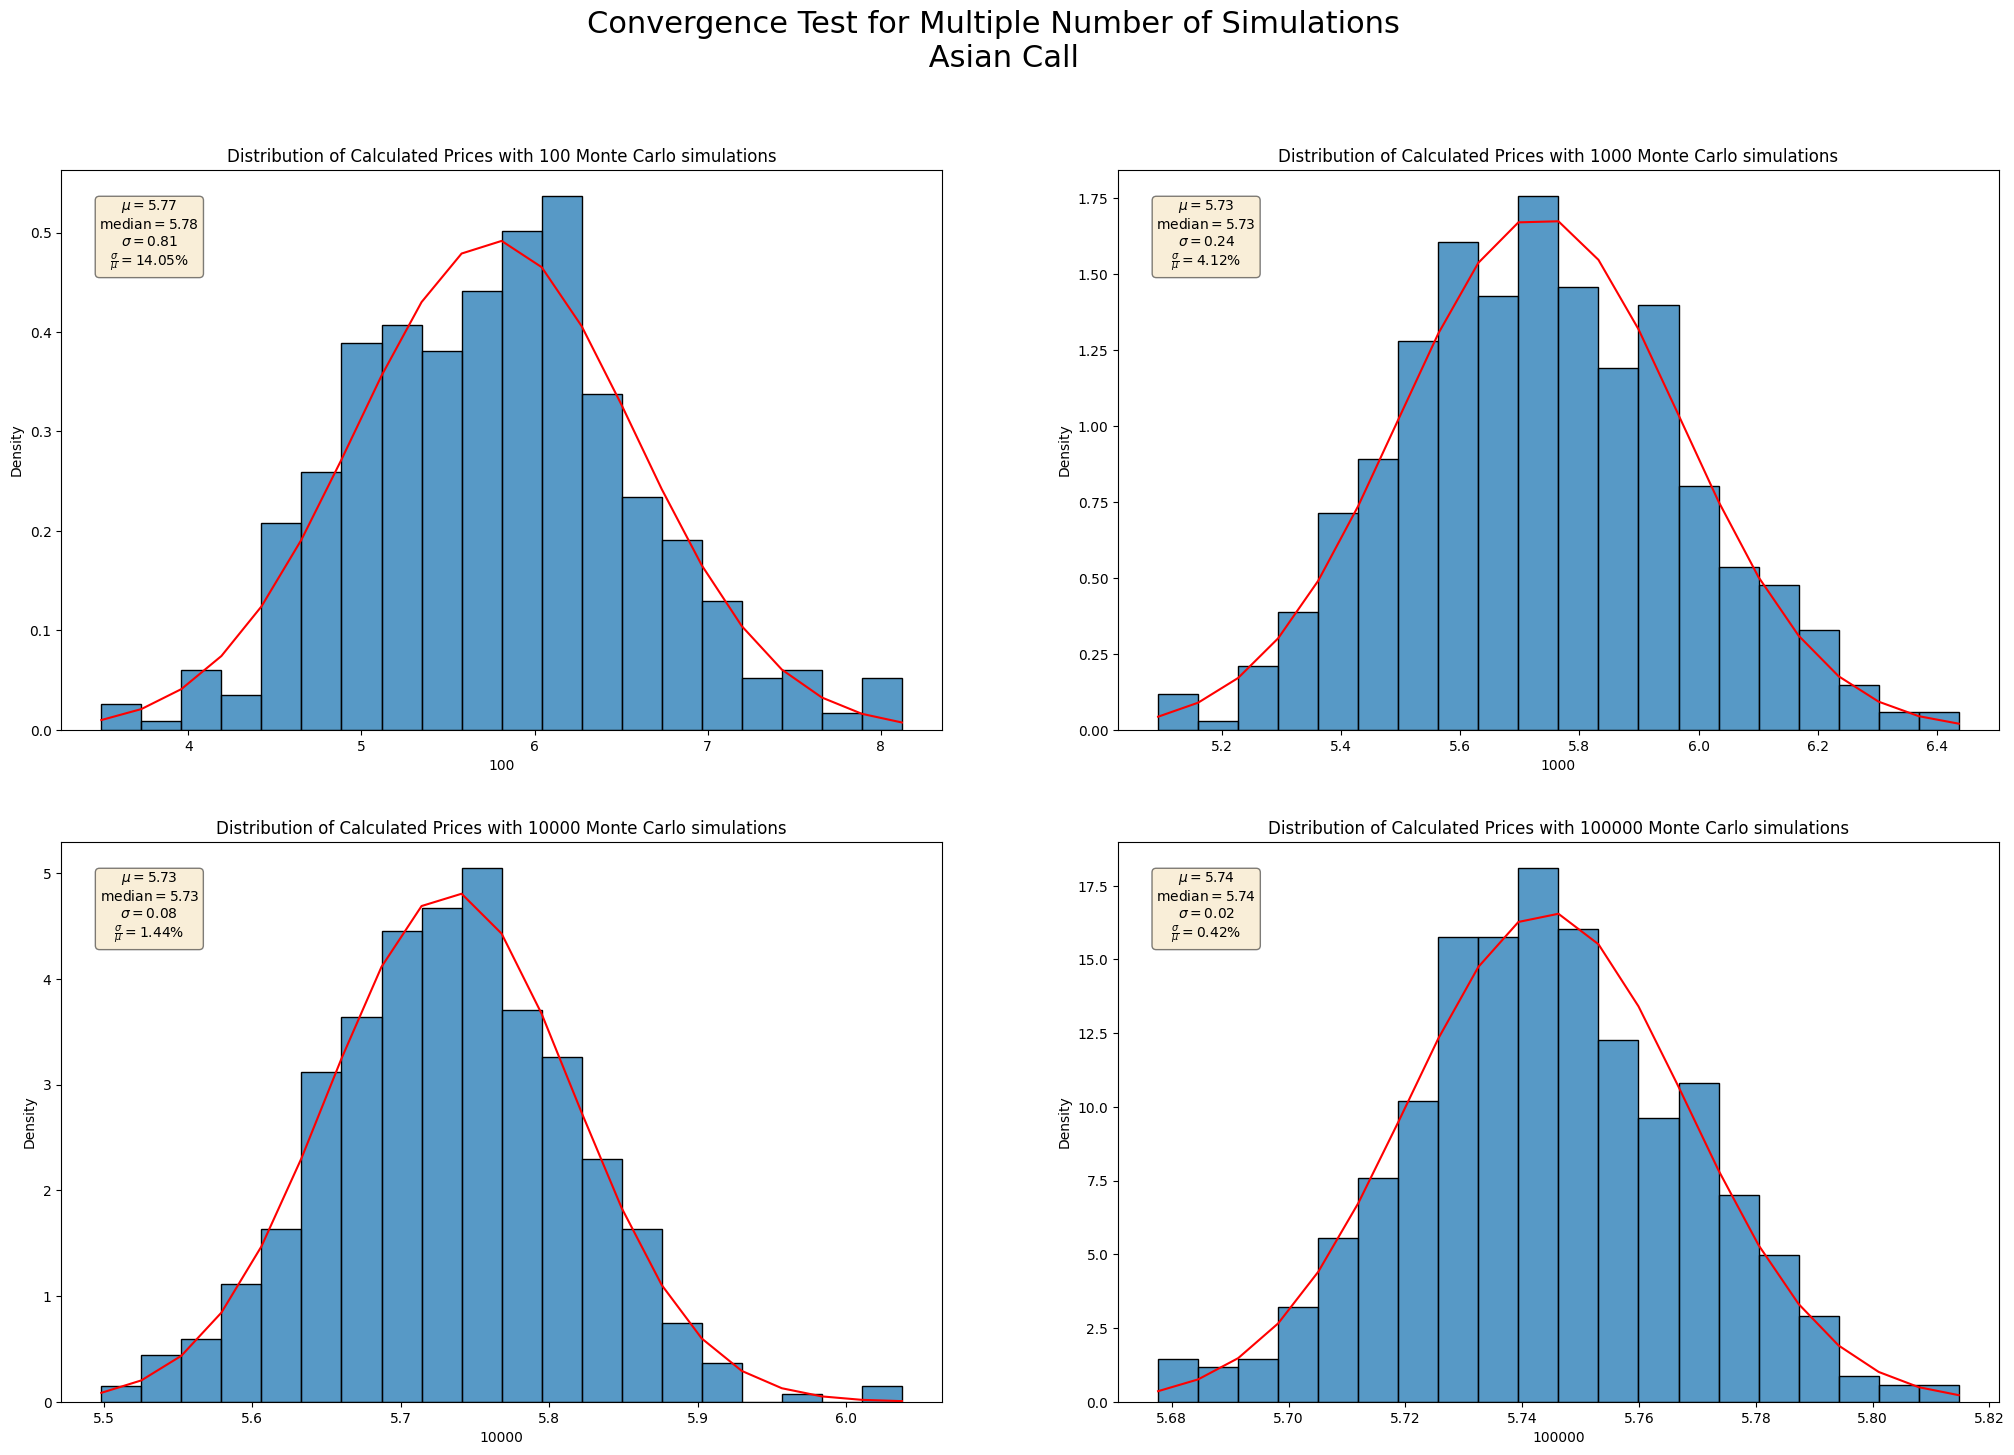

In [4]:
n_prices = 500
simulations_range = [100, 1000, 10000, 100000]

df_prices_convergence = pd.DataFrame(index=range(0, n_prices),
                                     columns=simulations_range)

df_runtime = pd.DataFrame(index=range(0, n_prices),
                          columns=simulations_range)

for j in simulations_range:
    
    for i in range(0,n_prices):
        start_time = time.time()
        df_prices_convergence.loc[i,j] = asian_call(s0, strike_E, expiry_T, sigma, risk_free, n_periods, j)
        df_runtime.loc[i,j] = time.time()-start_time

plt.clf()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25,16))
fig.suptitle('Convergence Test for Multiple Number of Simulations \n Asian Call', 
             fontsize=22)

axis_to_n_sim = {ax1: 100, ax2: 1000, ax3: 10000, ax4: 100000}

for axis in [ax1, ax2, ax3, ax4]:

    data = df_prices_convergence.loc[:, axis_to_n_sim[axis]]
    bins = np.histogram(df_prices_convergence.loc[:, axis_to_n_sim[axis]], 
                        bins=20)[1]
    
    bins = [float(x) for x in bins]

    sns.histplot(data,stat='density',
                 bins=20,
                 ax=axis)

    sns.lineplot(ax=axis,x=bins,
                y=gaussian(data=data,
                           bins=bins),
                color='red')

    ax=axis.set_title(f'Distribution of Calculated Prices with {axis_to_n_sim[axis]} Monte Carlo simulations')

    textstr = '\n'.join((
        r'$\mu=%.2f$' % (data.mean(), ),
        r'$\mathrm{median}=%.2f$' % (data.median(), ),
        r'$\sigma=%.2f$' % (data.std(), ),
        r'$\frac{\sigma}{\mu}=%.2f$'% (data.std()*100/data.mean(), )+'%'))

    axis.text(0.1, 0.95, textstr, 
              horizontalalignment='center', 
              verticalalignment='top', 
              transform=axis.transAxes, 
              bbox=props)

<Figure size 640x480 with 0 Axes>

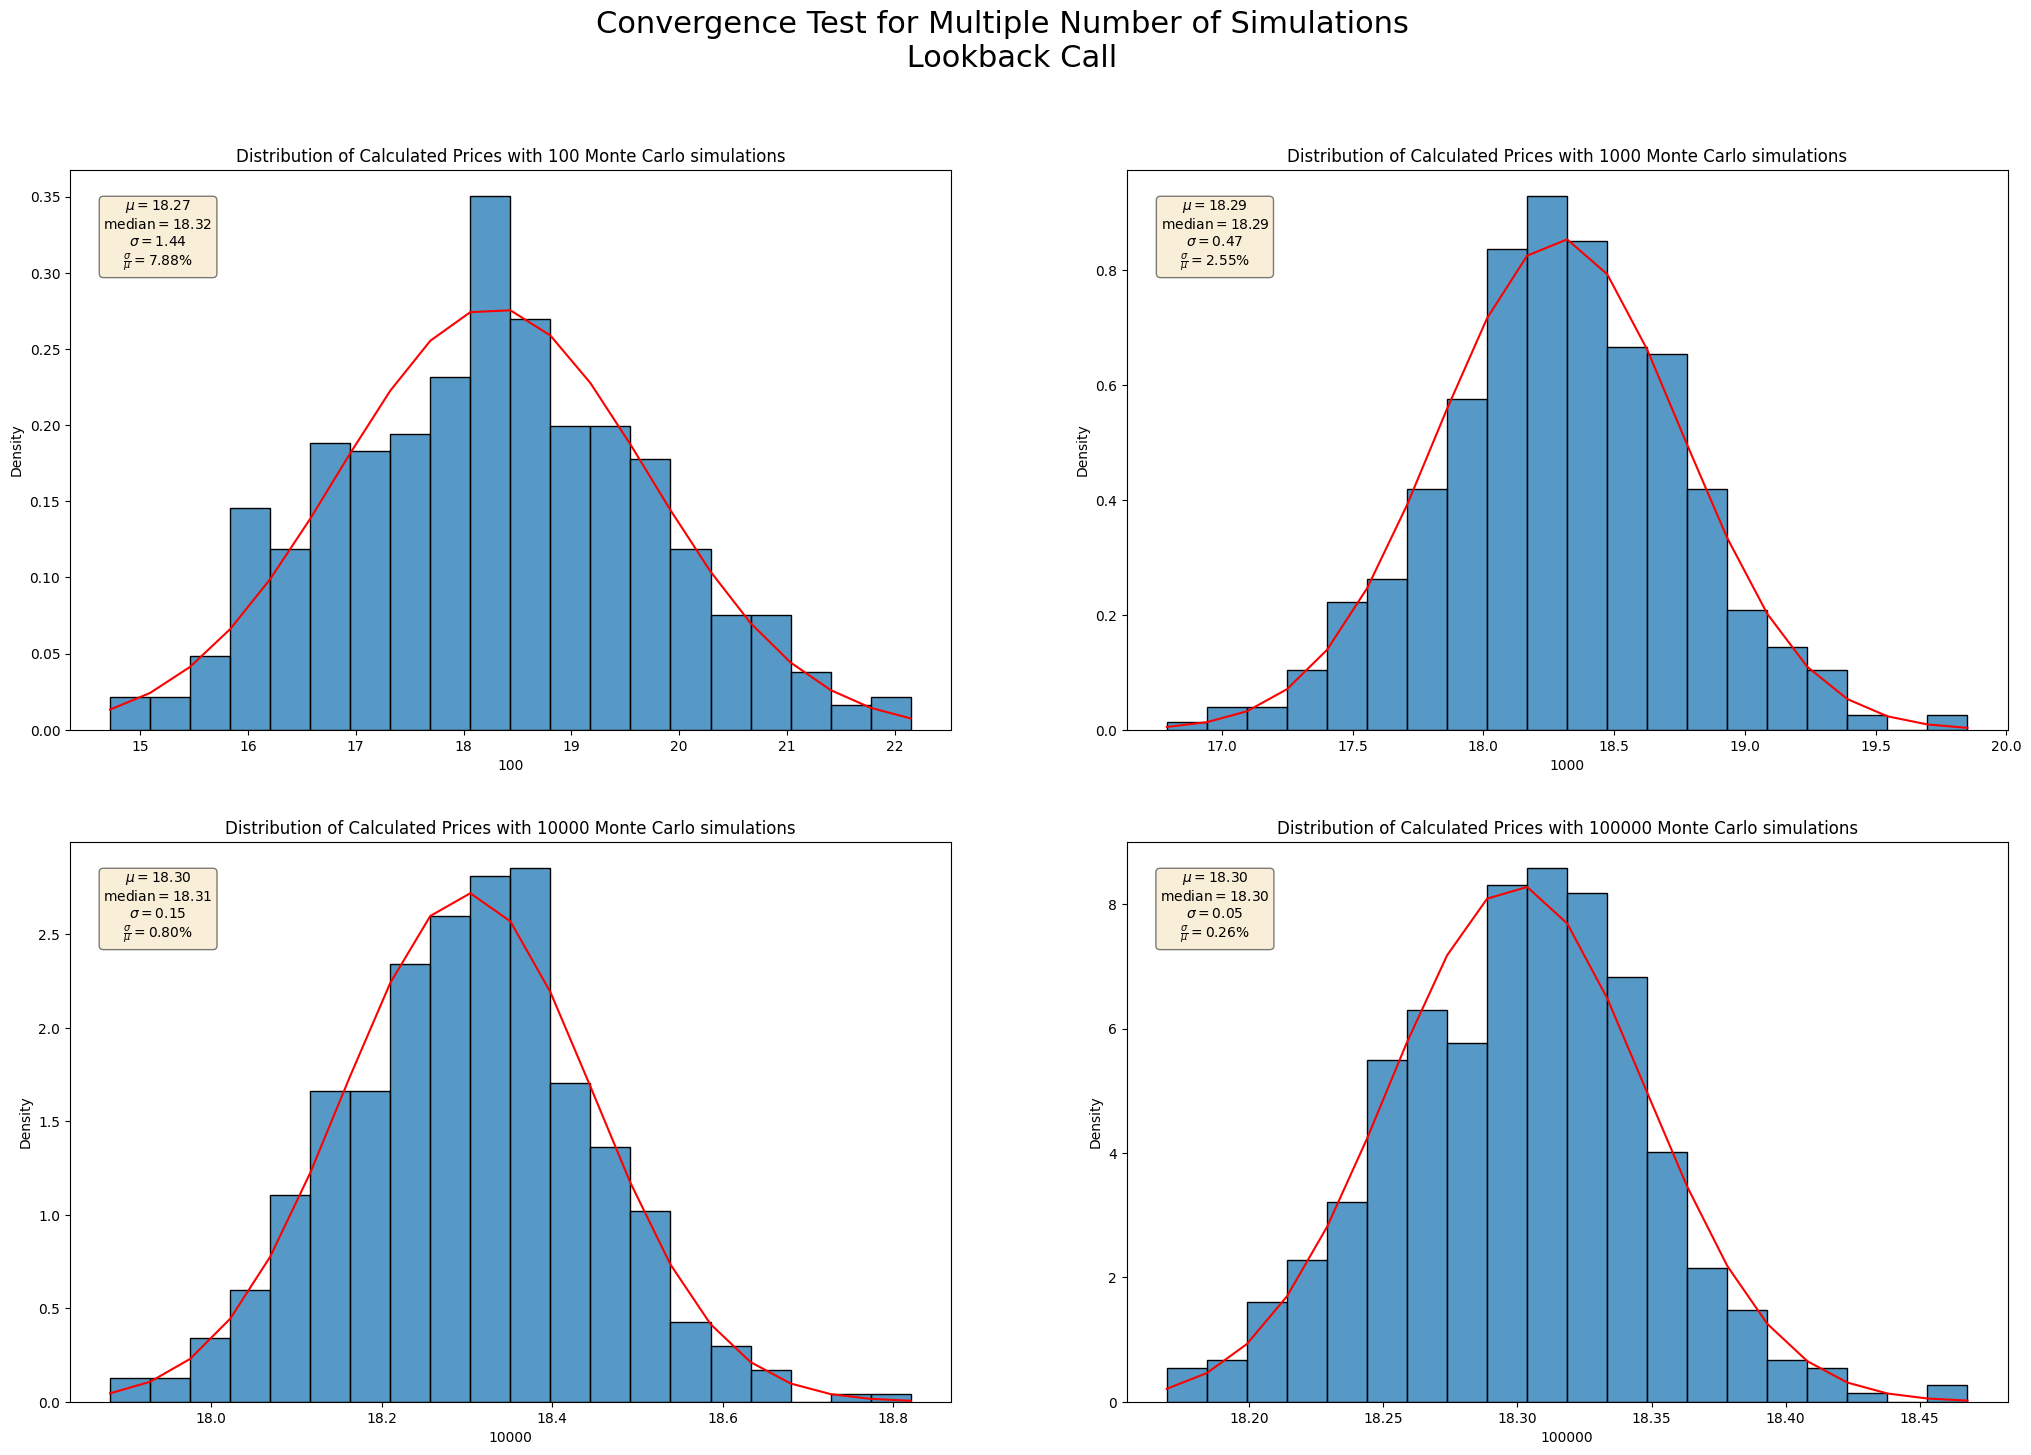

In [5]:
n_prices = 500
simulations_range = [100, 1000, 10000, 100000]

df_prices_convergence = pd.DataFrame(index=range(0, n_prices),
                                     columns=simulations_range)

df_runtime = pd.DataFrame(index=range(0, n_prices),
                          columns=simulations_range)

for j in simulations_range:
    
    for i in range(0,n_prices):
        start_time = time.time()
        df_prices_convergence.loc[i,j] = \
            lookback_call(s0, strike_E, expiry_T, sigma, risk_free, n_periods, j)
        
        df_runtime.loc[i,j] = time.time()-start_time
        
plt.clf()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25,16))
fig.suptitle('Convergence Test for Multiple Number of Simulations \n Lookback Call', 
             fontsize=22)

axis_to_n_sim = {ax1: 100, ax2: 1000, ax3: 10000, ax4: 100000}

for axis in [ax1, ax2, ax3, ax4]:

    data = df_prices_convergence.loc[:, axis_to_n_sim[axis]]
    bins = np.histogram(df_prices_convergence.loc[:, axis_to_n_sim[axis]], 
                        bins=20)[1]
    
    bins = [float(x) for x in bins]

    sns.histplot(data,stat='density',
                bins=20,
                ax=axis)

    sns.lineplot(ax=axis,x=bins,
                y=gaussian(data=data, bins=bins),
                color='red')

    ax=axis.set_title(f'Distribution of Calculated Prices with {axis_to_n_sim[axis]} Monte Carlo simulations')

    textstr = '\n'.join((
        r'$\mu=%.2f$' % (data.mean(), ),
        r'$\mathrm{median}=%.2f$' % (data.median(), ),
        r'$\sigma=%.2f$' % (data.std(), ),
        r'$\frac{\sigma}{\mu}=%.2f$'% (data.std()*100/data.mean(), )+'%'))

    axis.text(0.1, 0.95, 
              textstr, 
              horizontalalignment='center', 
              verticalalignment='top', 
              transform=axis.transAxes, 
              bbox=props)



# Runtime

In [6]:
df_section1 = pd.DataFrame(pd.concat(
    [df_runtime.mean(), df_prices_convergence.std()], axis=1).to_numpy(), 
    columns=['Avg_Runtime_(seconds)', 'Std_Dev_Prices'],
    index=pd.Index(simulations_range,name='Number of Simulations'))

df_section1

,Avg_Runtime_(seconds),Std_Dev_Prices
Number of Simulations,,
100,0.001155,1.439804
1000,0.004664,0.46695
10000,0.041766,0.146641
100000,0.40299,0.048037


In [17]:
df_section1['Avg_Runtime_(seconds)'].index

Index([100, 1000, 10000, 100000], dtype='int64', name='Number of Simulations')

In [16]:
scipy.stats.linregress(
    x=df_section1['Avg_Runtime_(seconds)'].astype(float), 
    y=df_section1['Avg_Runtime_(seconds)'].index
    )

LinregressResult(slope=248705.42904539494, intercept=-240.08758298307657, rvalue=0.9999977833941183, pvalue=2.2166058817330123e-06, stderr=370.2799772110383, intercept_stderr=75.014541016194)

Linear Regression - Runtime vs Simulations: 

      Slope:248705.42904539494

      Intercept:-240.08758298307657
  
      R²: 0.9999977833941183


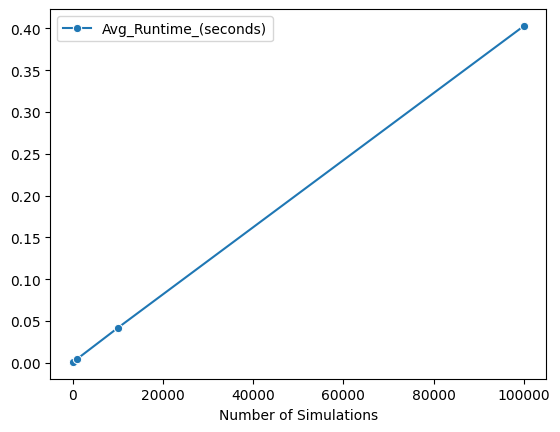

In [18]:
slope, intercept, r, p, se = scipy.stats.linregress(
    x=df_section1['Avg_Runtime_(seconds)'].astype(float), 
    y=df_section1['Avg_Runtime_(seconds)'].index
    )

runtime_plot = sns.lineplot(data=df_section1['Avg_Runtime_(seconds)'].to_frame(), markers=['o'])

print(f"""Linear Regression - Runtime vs Simulations: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r}""")

Linear Regression - Log Std Deviation of Prices vs Log Simulations: 

      Slope:-0.4933189278787766

      Intercept:2.63753858490902
  
      R²: -0.999976596247231


[None]

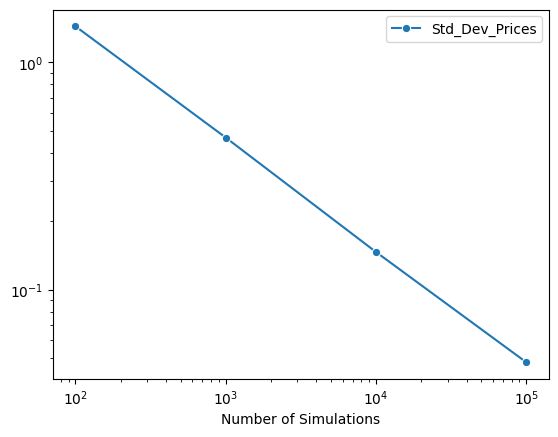

In [20]:
slope, intercept, r, p, se = scipy.stats.linregress(x=np.log(df_section1['Std_Dev_Prices'].index), 
                                                    y=np.log(df_section1['Std_Dev_Prices'].astype(float)))

print(f"""Linear Regression - Log Std Deviation of Prices vs Log Simulations: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r}""")

runtime_plot = sns.lineplot(data=df_section1['Std_Dev_Prices'].to_frame(), markers=['o'])
runtime_plot.set(xscale='log')
runtime_plot.set(yscale='log')

# Section 1 - Conclusion

- We can see that the calculated option prices converge in both cases, centered around normal distributions. <br>
- As expected, the averages of the distributions are the same, and the standard deviation of the distributions falls with the increased number of stock price paths. <br>
- Using linear regression, we can notice that the runtime increases linearly with the number of simulations while the error decreases logarithmically with the number of simulations <br>
- With 10e5 the relative error, on average, is less than 0.5%, thus from now on, we will use this number of simulations <br>
- We are presenting all option prices calculated with this number of simulations below

In [21]:
pd.set_option("display.precision", 2)
n_simulations = 100000

inputs = (s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations)

pd.DataFrame(columns=['Asian', 'Lookback'], 
             index=['Call', 'Put'], 
             data = [[asian_call(*inputs), lookback_call(*inputs)],
                     [asian_put(*inputs), lookback_put(*inputs)]])

,Asian,Lookback
Call,5.72,18.30
Put,3.30,11.71


# Section 2 - Sensitivity Analysis of Option Prices to its Parameters <br>
- In this section, we are plotting the options prices and the derivatives of those prices with respect to the option parameters in different stock price levels. <br>
- All derivatives are taken numerically, using the Finite Difference Method. <br>
- The Greeks are calculated on different levels of time to expiration, to evidence how the sensitivities change over time

Text(0.5, 1.0, 'Asian Put Rho')

<Figure size 640x480 with 0 Axes>

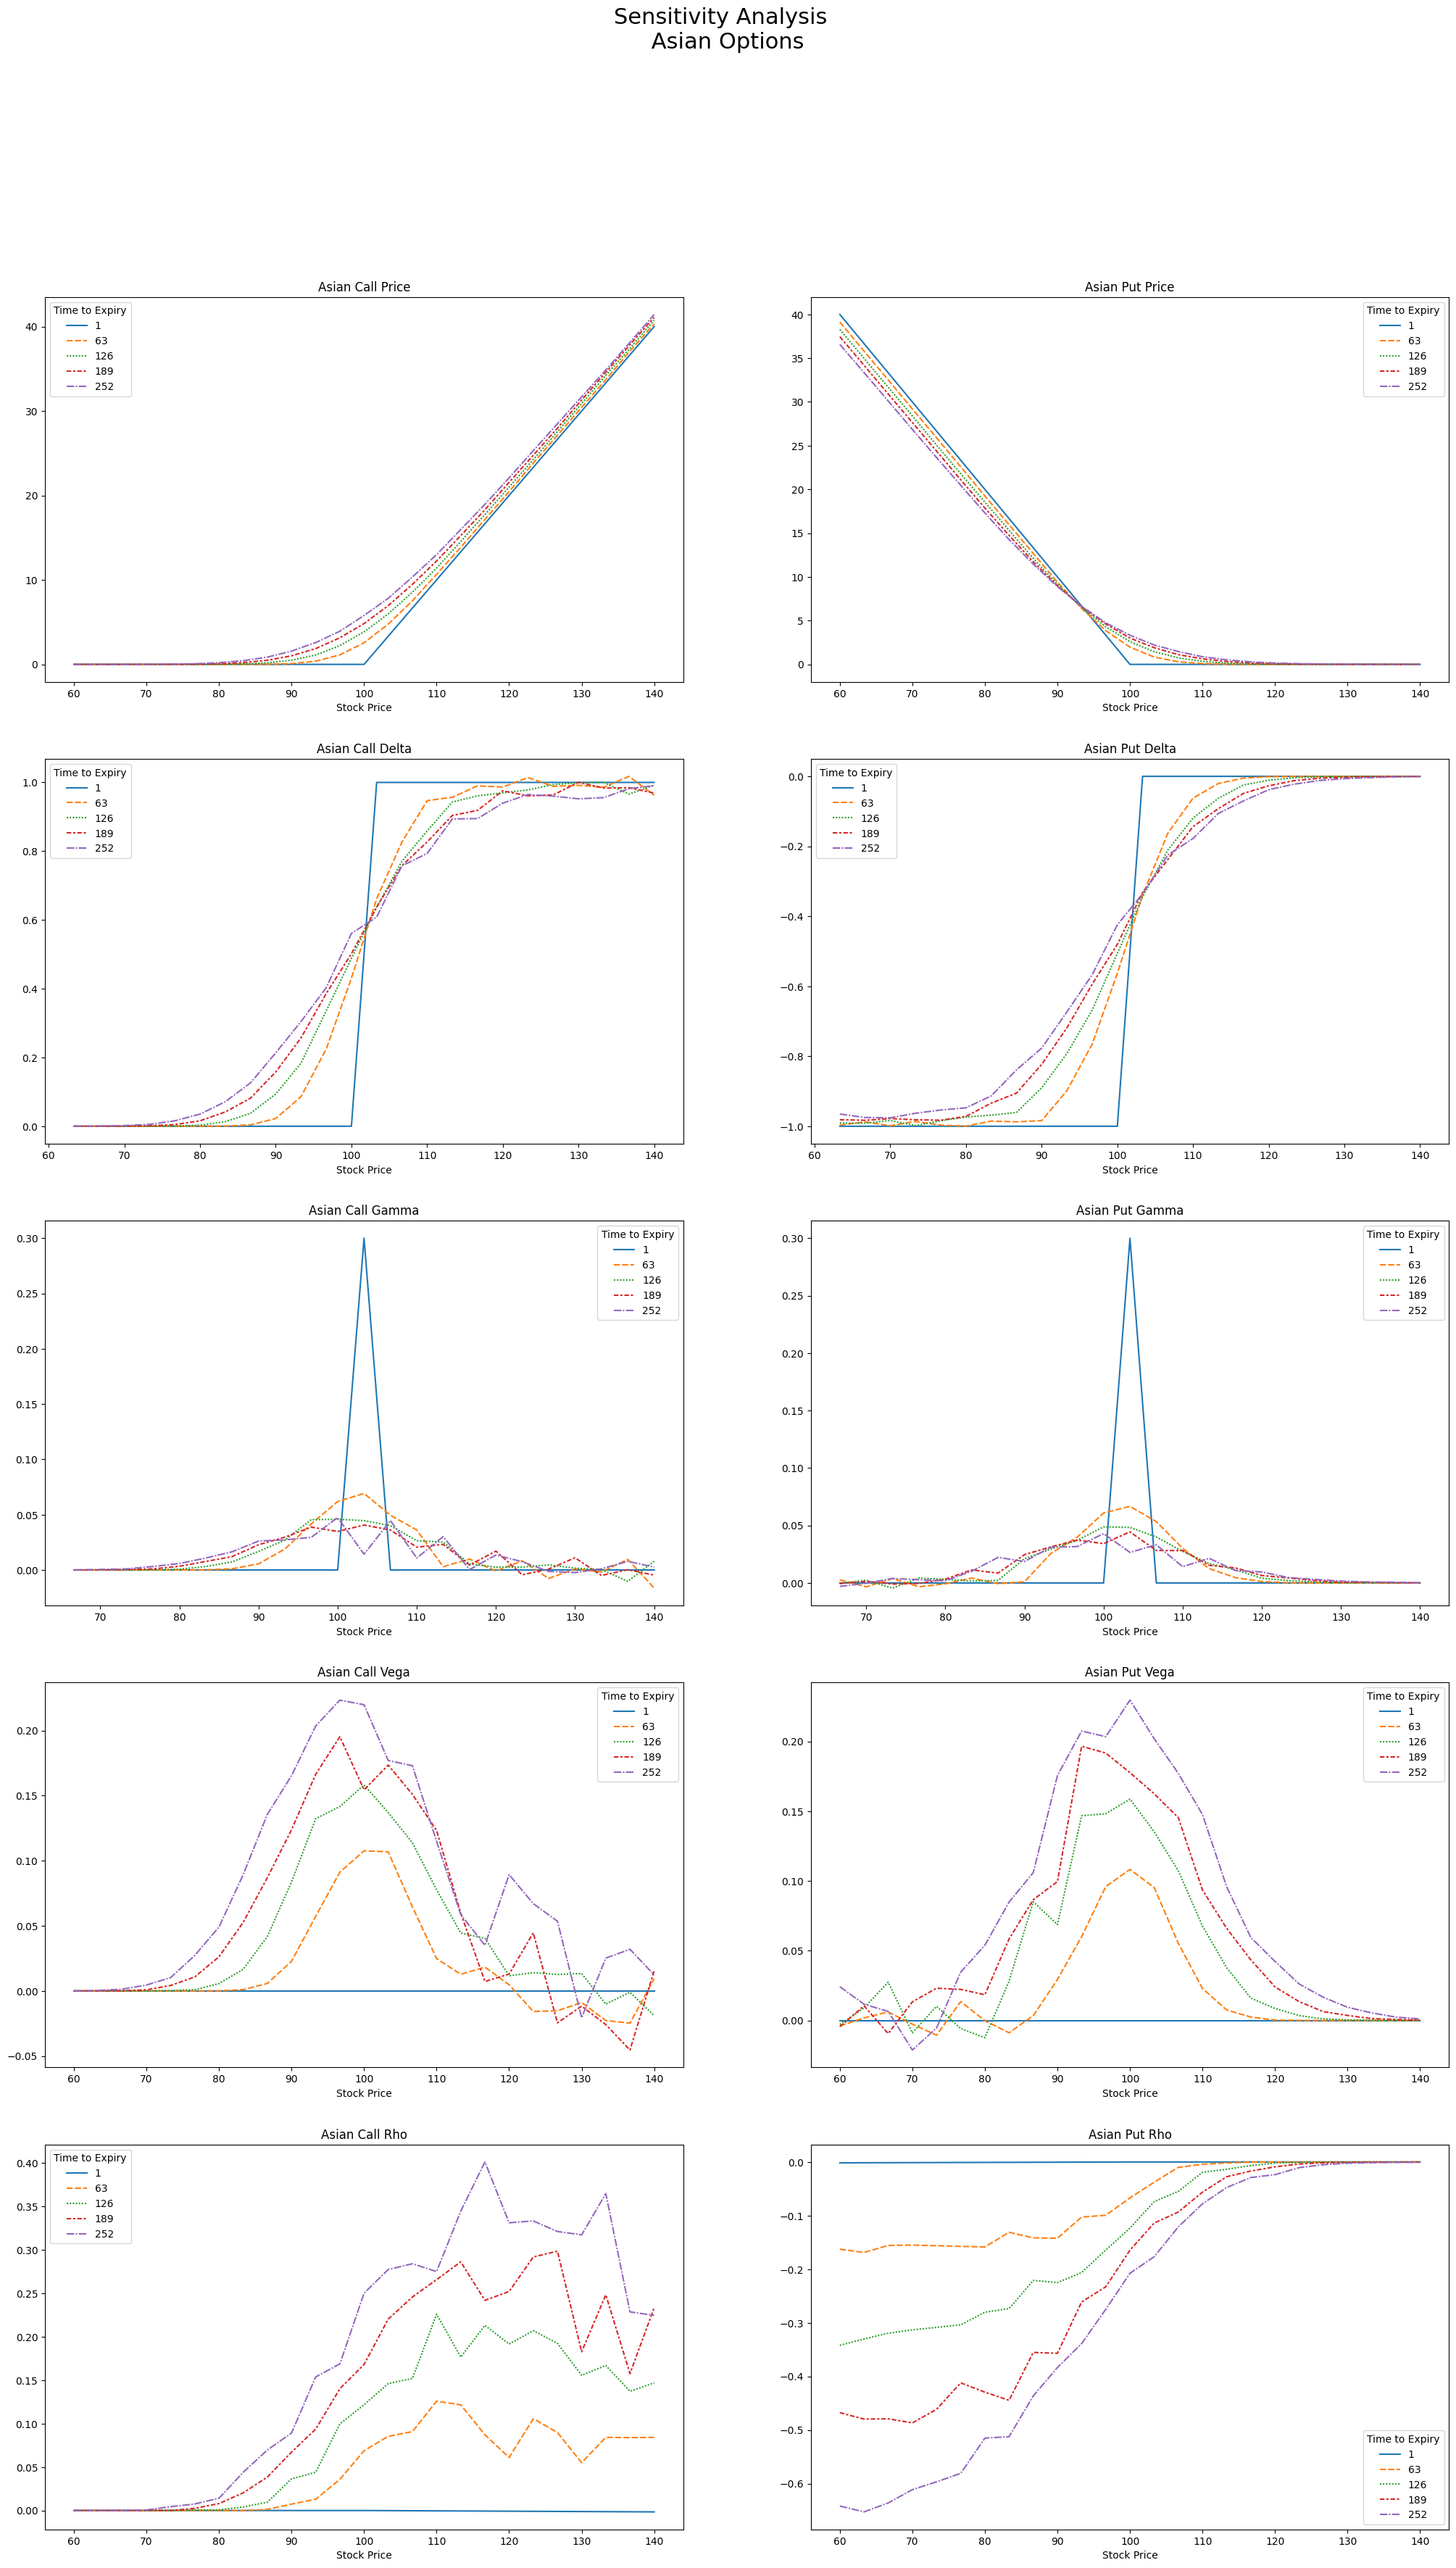

In [22]:
n_scenarios = 25

price_range = np.linspace(60, 140, n_scenarios)
time_to_expiry_range = [252, 189, 126, 63, 1]

asian_call_greeks = option_greeks('asian_call', price_range, time_to_expiry_range, strike_E, sigma, risk_free, n_periods, n_simulations)
asian_put_greeks = option_greeks('asian_put', price_range, time_to_expiry_range, strike_E, sigma, risk_free, n_periods, n_simulations)

plt.clf()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25,40))
fig.suptitle('Sensitivity Analysis \n Asian Options', 
             fontsize=22)

#Asian Call
sns.lineplot(asian_call_greeks.Price.unstack().T,ax=ax[0,0])
ax[0, 0].set_title('Asian Call Price')

sns.lineplot(asian_call_greeks.Delta.unstack().T,ax=ax[1,0])
ax[1, 0].set_title('Asian Call Delta')

sns.lineplot(asian_call_greeks.Gamma.unstack().T,ax=ax[2,0])
ax[2, 0].set_title('Asian Call Gamma')

sns.lineplot(asian_call_greeks.Vega.unstack().T,ax=ax[3,0])
ax[3, 0].set_title('Asian Call Vega')

sns.lineplot(asian_call_greeks.Rho.unstack().T,ax=ax[4,0])
ax[4, 0].set_title('Asian Call Rho')

#Asian Put
sns.lineplot(asian_put_greeks.Price.unstack().T,ax=ax[0,1])
ax[0, 1].set_title('Asian Put Price')

sns.lineplot(asian_put_greeks.Delta.unstack().T,ax=ax[1,1])
ax[1, 1].set_title('Asian Put Delta')

sns.lineplot(asian_put_greeks.Gamma.unstack().T,ax=ax[2,1])
ax[2, 1].set_title('Asian Put Gamma')

sns.lineplot(asian_put_greeks.Vega.unstack().T,ax=ax[3,1])
ax[3, 1].set_title('Asian Put Vega')

sns.lineplot(asian_put_greeks.Rho.unstack().T,ax=ax[4,1])
ax[4, 1].set_title('Asian Put Rho')

In [23]:
n_scenarios = 25

price_range = np.linspace(60, 140, n_scenarios)
time_to_expiry_range = [252, 189, 126, 63, 1]

asian_call_greeks = option_greeks('lookback_call', price_range, time_to_expiry_range, strike_E, sigma, risk_free, n_periods, n_simulations)
asian_put_greeks = option_greeks('lookback_put', price_range, time_to_expiry_range, strike_E, sigma, risk_free, n_periods, n_simulations)

plt.clf()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25,40))
fig.suptitle('Sensitivity Analysis \n Lookback Options', 
             fontsize=22)

#Asian Call
sns.lineplot(asian_call_greeks.Price.unstack().T, ax=ax[0,0])
ax[0, 0].set_title('Lookback Call Price')

sns.lineplot(asian_call_greeks.Delta.unstack().T, ax=ax[1,0])
ax[1, 0].set_title('Lookback Call Delta')

sns.lineplot(asian_call_greeks.Gamma.unstack().T, ax=ax[2,0])
ax[2, 0].set_title('Lookback Call Gamma')

sns.lineplot(asian_call_greeks.Vega.unstack().T, ax=ax[3,0])
ax[3, 0].set_title('Lookback Call Vega')

sns.lineplot(asian_call_greeks.Rho.unstack().T, ax=ax[4,0])
ax[4, 0].set_title('Lookback Call Rho')

#Asian Put
sns.lineplot(asian_put_greeks.Price.unstack().T, ax=ax[0,1])
ax[0, 1].set_title('Lookback Put Price')

sns.lineplot(asian_put_greeks.Delta.unstack().T, ax=ax[1,1])
ax[1, 1].set_title('Lookback Put Delta')

sns.lineplot(asian_put_greeks.Gamma.unstack().T, ax=ax[2,1])
ax[2, 1].set_title('Lookback Put Gamma')

sns.lineplot(asian_put_greeks.Vega.unstack().T, ax=ax[3,1])
ax[3, 1].set_title('Lookback Put Vega')

sns.lineplot(asian_put_greeks.Rho.unstack().T, ax=ax[4,1])
ax[4, 1].set_title('Lookback Put Rho')

# Section 2 - Conclusions <br>
- # 1. Similarities between Asian and Lookback options: <br>
 - We can see that both exotic options prices and Greeks follow, to some degree, the same patterns of prices and Greeks that its plain vanilla equivalents exhibit; <br>
 - For deep ITM options, the numerical calculation of the Greeks becomes somehow messy, due to the error in Monte Carlo simulations, the error is more evident for deep ITM because we expect low price changes on high option prices, and those tiny changes re lower than the error produced by Monte Carlo; <br>
 - We don't see the same pattern for deep OTM options because the absolute price of the option is very low, thus the absolute error is very low as well; <br>
 - To achieve smoothness on the Greeks, we would need a very high number of simulations (more than 1 million) to decrease the error, but this is unfeasible because it would require a very long runtime (tens of hours); <br>
<br>
- # 2.Differences between Asian and Lookback options: <br>
 - **Option Prices(call)**: The ITM asian call prices over time are spread across a narrow range, because once ITM, we don't expect that the average of the stock price will vary abruptly in the future, but in the ITM lookback call the maximum value can be much larger in the future than the present maximum;
 - **Option Prices(put)**: The ITM asian puts are valued lower than its exercise price, this is due to two factors: over time, the average price is expected to increase, and the discount factor on the risk-free rate. For the lookback put, the prices are distributed on a narrow range because we don't expect further new minimuns due to the long-term growth of the GBM;
 - **Delta**: The absolute deltas on ITM lookback calls (puts) are greater (lower) than one because in the future the maximum (minimum) historical value of a stock has more (less) potential to increase (decrease) than the stock itself;
 - **Vega**: The absolute values of vega are much higher for the lookback option than for asian options, this is expected because lookback options only depend on the extreme prices. <br>
 For asian options the vega follows the same pattern as european options, decreasing with moneyness, but for lookback calls, the prices seem to only to benefit from higher volatility, since the chances of generating a new maximum are higher, for lookback puts, the vega on ITM puts is quite high due to the higher chances of getting a new minimum;
  - **Rho**: No significant differences;

# Final Conclusion

Personally, this assignment helped me to practice important skills that can be broken down into some factors:

- # 1.Open-ended Problem: <br>
The task of interpreting a relatively simple assignment and especially thinking about how the results would be presented is particularly hard for me. <br>
I have spent more hours plotting different charts and trying different visualizations than coding the numerical methods, since that are a large number of variables, there are innumerous ways of showing the results<br>
Also, I have chosen to not using 3-D plots because I have difficulties with visualization in this form; <br>

- # 2.Expected Results vs Calculated Results: <br>
Before doing any calculation is important to have expected results in mind and check them with the calculation. For instance, I had an unexpected result in Section 1, after calculating that the relative error for a lookback call is lower than is for the asian call, all else equal. I was expecting a much larger error on lookback options because the maximum value of a GBM series has more variance than the average. I think that this shows that both options have the same level of path dependency;<br>
- # 3.Interpretation of Numerical Results: <br>
By explaining the obtained results, I had to create some intuitions to put the numerical results into words;


# References

- Paul Wilmott on Quantitative Finance Volume 1
- Paul Wilmott on Quantitative Finance Volume 2
- Python Labs - 06 Monte Carlo Simulation
